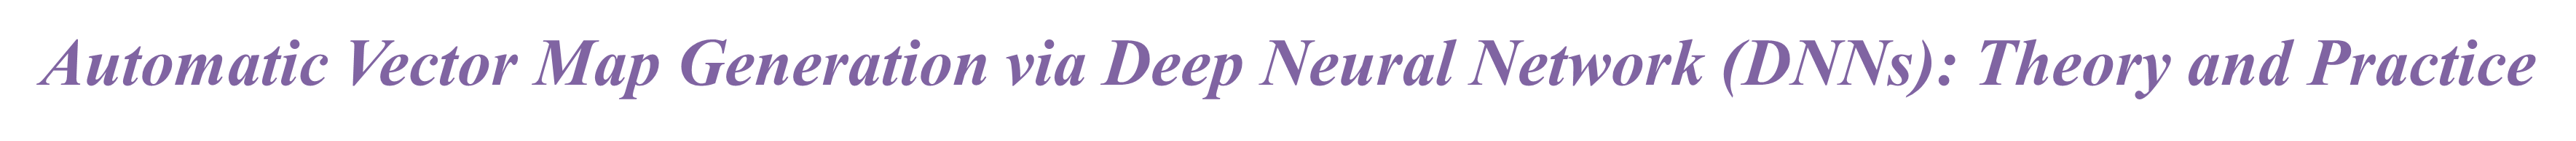

This notebook shows binary **BUILDING SEGMENTATION** in **Tensorflow-Keras** farmework. We will use a custom dataset from Yazd province of Iran. This task will classify pixel of input image as **BUILDING** or **NON-BUILDING**.

This notebook contains TWO section:

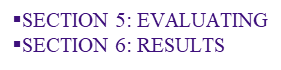


## LOAD DATASET

In [ ]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 38.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import rasterio
import cv2
import random

from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import recall_score

import tensorflow as tf
from keras.models import load_model

In [ ]:
# define some parameters
image_shape = (512,512,4)
label_shape = (512,512,1)

epoch = 50
batch_size = 6

num_class = 1


In [ ]:
#Mount(Connect) to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_RGBD = glob.glob('/content/drive/MyDrive/Data_complete/train/RGBD/Images/*.tif')
train_MAP = glob.glob('/content/drive/MyDrive/Data_complete/train/MAP/Images/*.tif')



In [ ]:
train_RGBD.sort()
train_MAP.sort()


In [ ]:
path_TEST_RGBD = train_RGBD[100:130]
path_TEST_MAP = train_MAP[100:130]




In [ ]:
  
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self,
                 paths_list,
                 batch_size,
                 epoch,
                 target_size=(512, 512),
                 MAP = False,
                 RGBD=False):
        
        self.epoch = epoch
        self.batch_size = batch_size
        self.paths_list = paths_list
        self.target_size = target_size
        self.n = len(paths_list)
        self.MAP = MAP
        self.RGBD = RGBD
       
      
    
    def __get_input(self, path, target_size):
      # read RGBD images and GT
          #GT
        if self.MAP:
            image = rasterio.open(path).read()    # shape = [number of chennel, height, width], dtype = float32
            image = np.rollaxis(image, 0, 3)      # shape = [height, width, number of chennel], dtype = float32
            # image = cv2.imread(path)    # dtype = uint8
            # convert_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)   # conver RGB To Grayscale image , dtype = float32, shape  = [height, width]  
            # image = convert_image[..., np.newaxis]   # shape = [height, width, 1]
            method = 'nearest'
          #RGBD  
        elif self.RGBD:
            image = rasterio.open(path).read()    # shape = [number of chennel, height, width], dtype = float32
            image = np.rollaxis(image, 0, 3)      # shape = [height, width, number of chennel], dtype = float32
            method = 'bilinear'
            # Resize RGBD image and GT
        image = tf.image.resize(image,(target_size[0], target_size[1]), method=method).numpy()
        
        return image

    
    def __get_data(self, batch_path):
        # Generates data containing batch_size samples
        
        X_batch = np.asarray([self.__get_input(image_path, self.target_size) for image_path in batch_path])

        return X_batch
    
    def __getitem__(self, index):
        # get the index of list                               # image = [image1, image2, image3, image4]
        i = (index*self.batch_size) % self.n                  # e.g. index = 1  ==> (1x2) % 90 = 2     % return the remainder of dividing
        batch_path = self.paths_list[i:i+self.batch_size]     # batch_path = path_list [2 : 2+2]
        X = self.__get_data(batch_path)        
        return X
    
    def __len__(self):
      # How many images does the custom generator generate?
                                                               # epoch = 50, number of images = 90, batch_size = 2
        return  self.epoch*self.n // self.batch_size           # e.g.  50 * 90 // 2 = 2250    // is Floor division that returns the largest possible integer
    

In [ ]:
rgbd_test_gen = CustomDataGen(path_TEST_RGBD, batch_size=batch_size, epoch=1, RGBD=True)
GT_test_gen = CustomDataGen(path_TEST_MAP, batch_size=batch_size, epoch=1, MAP=True)

In [ ]:
print('Number of test images: {} '.format(len(path_TEST_RGBD)))
print('Number of test images: {} '.format(len(path_TEST_MAP)))

Number of test images: 30 
Number of test images: 30 


RGBD image shape is (6, 512, 512, 4)
Ground Truth image shape is (6, 512, 512, 1)


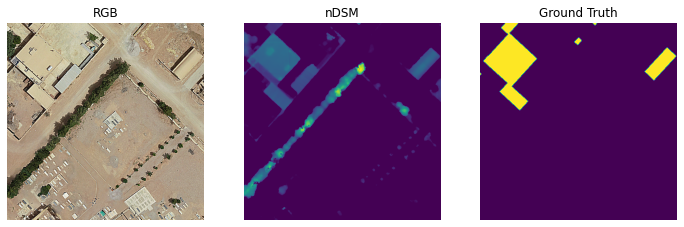

In [ ]:
image_number = random.randint(0, len(path_TEST_RGBD)-1)
x = rgbd_test_gen[image_number]
print('RGBD image shape is {}'.format(x.shape))
y = GT_test_gen[image_number]
print('Ground Truth image shape is {}'.format(y.shape))



fig, axes = plt.subplots(1, 3, figsize=(12, 6))
axes = axes.ravel()

axes[0].imshow(x[0,..., 0:3])
axes[0].title.set_text('RGB')
axes[0].axis('off')

axes[1].imshow(x[0,..., 3])
axes[1].title.set_text('nDSM')
axes[1].axis('off')

axes[2].imshow(y[0, ... , 0])
axes[2].title.set_text('Ground Truth')
axes[2].axis('off')


None


# SECTION 5:EVALUATING

**LOAD MODEL**

In [ ]:
model = load_model('/content/drive/MyDrive/403-WORKSHOP_DNNs for Map Generation_GEOSPATIAL CONF 2023/STUDENT/model_simple_U-Net.h5')

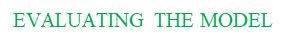

[Evaluate](https://keras.io/api/models/model_training_apis/)

* Return the loss value & metrics values for the model in test mode



---

[Predict](https://keras.io/api/models/model_training_apis/)

* Generates output predictions for the input samples

In [ ]:
# total evaluation
evaluation = model.evaluate(
    zip(rgbd_test_gen,GT_test_gen),
    verbose=1,
  )

5/5 [==============================] - 175s 34s/step - loss: 0.1657 - accuracy: 0.9570 - recall: 0.8606 - precision: 0.9637


In [ ]:
# predict all maps at once
map_predict = model.predict(
    zip(rgbd_test_gen,GT_test_gen),
    verbose=1,
)


5/5 [==============================] - 169s 34s/step


# SECTION 6:RESULTS

1/1 [==============================] - 47s 47s/step
0
F1-score    0.5042
IOU         0.337
Recall      0.3371
---------------------------------------------------------------------


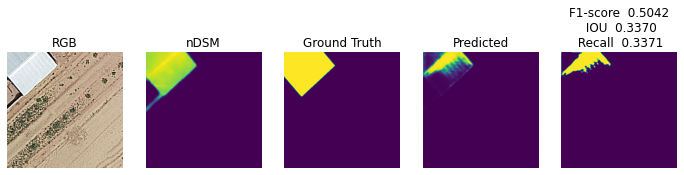

1/1 [==============================] - 45s 45s/step
1
F1-score    0.8929
IOU         0.8065
Recall      0.8066
---------------------------------------------------------------------


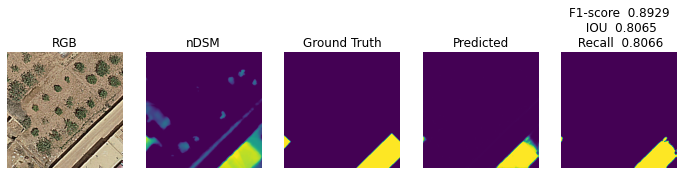

1/1 [==============================] - 49s 49s/step
2
F1-score    0.8502
IOU         0.7395
Recall      0.7407
---------------------------------------------------------------------


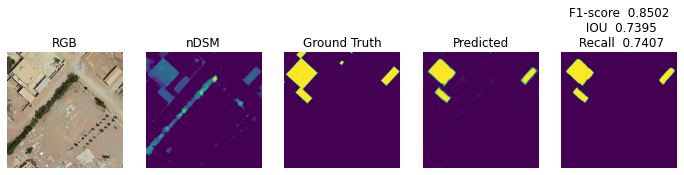

1/1 [==============================] - 45s 45s/step
3
F1-score    0.939
IOU         0.885
Recall      0.8872
---------------------------------------------------------------------


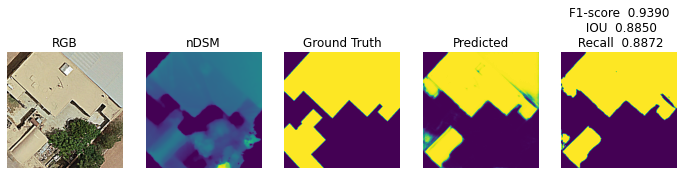

1/1 [==============================] - 45s 45s/step
4
F1-score    0.6884
IOU         0.5249
Recall      0.5249
---------------------------------------------------------------------


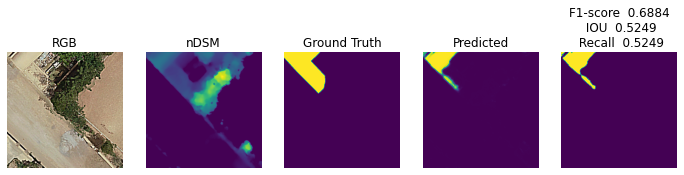

In [ ]:
# plot results per sample

ns = len(rgbd_test_gen)
for n in range(ns):
    x = rgbd_test_gen[n]
    y = GT_test_gen[n]
    y_hat = model.predict(x)
    y_hat2 = model.predict(x)
    T = 0.5
    y_hat2[y_hat2>T]  = 1
    y_hat2[y_hat2<=T] = 0
    
    # calculate metrics
    f1 = f1_score(y[0].flatten(), y_hat2[0].flatten())
    iou = jaccard_score(y[0].flatten(), y_hat2[0].flatten())
    recall = recall_score(y[0].flatten(), y_hat2[0].flatten())

    print(n)
    print('F1-score   ',round(f1, 4))
    print('IOU        ', round(iou, 4))
    print('Recall     ', round(recall, 4))
    print('---------------------------------------------------------------------')
    
    # plot a prediction map
    fig, axes = plt.subplots(1, 5, figsize=(12, 6))
    axes = axes.ravel()
    
    axes[0].imshow(x[0,...,0:3])
    axes[0].title.set_text('RGB')
    axes[0].axis('off')
    
    axes[1].imshow(x[0,..., 3])
    axes[1].title.set_text('nDSM')
    axes[1].axis('off')
    
    axes[2].imshow(y[0,...,0])
    axes[2].title.set_text('Ground Truth')
    axes[2].axis('off')
    
    axes[3].imshow(y_hat[0,...,0])
    axes[3].title.set_text('Predicted')
    axes[3].axis('off')
    
    #textstr = 'F1-score %.4f\n IOU %.4f\n Recall %.4f'%(f1, iou, recall_score)
    axes[4].imshow(y_hat2[0,...,0])
    axes[4].title.set_text('F1-score  %.4f\n IOU  %.4f\n Recall  %.4f'%(f1, iou, recall))
    axes[4].axis('off')
    plt.show()
   